# **Topic Identification**
Topic identification is the challenge of automatically finding topics
in a given text. This can be done in supervised and unsupervised ways. For example, an algorithm labels newspaper articles with known topics such
as ”sports,” ”politics,” or ”culture.” In this case, we have predefined topics and labeled training data and could train our model in a supervised way. This is called topic classification. If we do not know the topics in advance and want our algorithm to find clusters of similar topics, we deal with topic modeling or topic discovery, in an unsupervised way [[1]](#scrollTo=1eUuDaNxZ_ms).


This notebook shows examples of supervised topic identification with ``simpletransformers``.

## **Supervised topic classification with ``simpletransformers``**

### Install ``simpletransformers``

**Note:**<br>
Deep Learning (DL) models typically run on CUDA-enabled GPUs as the performance is better compared to running on a CPU [[5]](https://simpletransformers.ai/docs/usage/#enablingdisabling-cuda). CUDA is a parallel computing platform and programming model created by NVIDIA.

On all ``simpletransformers`` models, CUDA is enabled by default. Because of that, in order to proceed, you should enable CUDA in your GPU. If you are using Google Colab, you do not need to do anything since CUDA is pre-installed. On your Colab top menu, please click on "Runtime/Change runtime type" and choose "GPU". 
If you want to run the code without CUDA, you should disable it during the ["Create classification model"](#scrollTo=DmfjRTC21KCt)  process.


In [1]:
# Install simpletransformers library
# Important: After installing simpletransformers, if you see a button "RESTART RUNTIME", click on this button to restart the runtime.
!pip install simpletransformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 66.8 MB/s 
     |████████████████████████████████| 4.4 MB 61.2 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 1.8 MB 43.8 MB/s 
     |████████████████████████████████| 362 kB 54.2 MB/s 
     |████████████████████████████████| 6.6 MB 18.8 MB/s 
     |████████████████████████████████| 9.1 MB 25.2 MB/s 
     |████████████████████████████████| 596 kB 58.7 MB/s 
     |████████████████████████████████| 101 kB 11.2 MB/s 
     |████████████████████████████████| 181 kB 59.9 MB/s 
     |████████████████████████████████| 145 kB 52.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 140 kB 54.0 MB/s 
     |████████████████████████████████| 1.1 MB 58.7 MB/s 
     |██████████████████████████████

### Download dataset

We will download the dataset from [kaggle.com](https://www.kaggle.com). For this, you must sign up for an account first.

To load the dataset into colab, you can download the dataset:
-  to your local drive and upload it to colab environment
-  directly from kaggle.com

In this section, we will download the dataset from kaggle.com.

##### 1- Create Kaggle API Token

For authentication, you should create an api-token in your Kaggle account page and then upload it to colab environment. By doing so, you allow colab to access your Kaggle account for downloading the dataset.

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. 
Then go to the 'Account' tab of your user profile (*kaggle.com/username/account*) and 
select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 

##### 1- Create folders

Create a kaggle folder in the colab environment.

In [1]:
# Create 'kaggle' folder
!mkdir '/content/kaggle'

In [2]:
# Prepare folders in the colab environment
import os
os.mkdir('/root/.kaggle')
os.chdir('/root/.kaggle')

##### 3- Upload Kaggle API Token

In [3]:
# After downloading the API Token from kaggle.com, upload it to colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emrahyener","key":"18159badcc78760ab64a5c9a80b62671"}'}

##### 3- Allocate permission

In [4]:
# Allocate the required permission for this API Token
## This code modifies the access such that only you can access and read the kaggle.json file
## The permission code 600 means "the owner can read and write"
os.chmod('/root/.kaggle/kaggle.json', 600)

# Get back to the Kaggle folder
os.chdir('/content/kaggle')

##### 4- Download and unpack dataset

In [5]:
# Download dataset
!kaggle datasets download -d rmisra/news-category-dataset

 35% 9.00M/25.4M [00:00<00:00, 52.7MB/s]
100% 25.4M/25.4M [00:00<00:00, 111MB/s] 


In [6]:
 # Unpack dataset
!unzip news-category-dataset.zip

Archive:  news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


In [7]:
# Get back to the default ('content/') location
!cd ..

### Import libraries

We import all necessary libraries. Among the ``simpletransformers`` library,
we also need functions from ``sklearn`` and the ``pandas``
library to load and extract our training text corpus from the
JSON file. In google-colab, ``pandas`` and ``sklearn`` are pre-installed [[1]](#scrollTo=1eUuDaNxZ_ms).


In [8]:
# Import the pandas library
import pandas as pd

# Import "ClassificationModel" for text classification tasks
from simpletransformers.classification import ClassificationModel

# Import "train_test_split" from the sklearn library
from sklearn.model_selection import train_test_split

# Import "preprocessing" package from sklearn
from sklearn import preprocessing


### Create pandas dataframe

We extract our dataset and import it into a ``pandas`` dataframe.




In [9]:
# Read data from JSON
df = pd.read_json("/content/kaggle/News_Category_Dataset_v2.json", orient="records", lines=True)

We list the first three rows to see the dataframe content:




In [10]:
# List the first three rows
df.head(3)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26


### Visualize categories for an overview
To have an idea about the category distribution, you can use the ``matplotlib`` library.

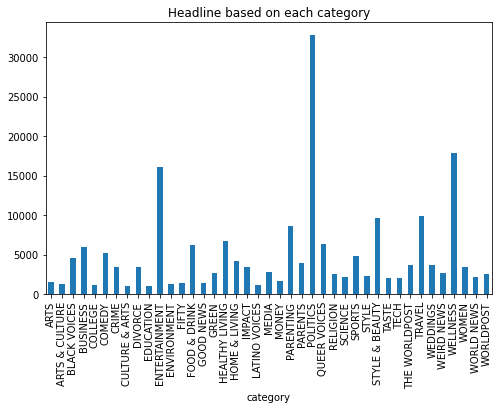

In [11]:
# Import pyplot from the matplotlib library
from matplotlib import pyplot as plt

# Plot a bar chart and display category distribution based on headline count
ax = df.groupby("category").count()["headline"].plot(kind="bar", 
                                                 figsize=(8, 5),
                                                 title="Headline based on each category")

plt.show()

### Data preparation

#### Create dataframe
Our classification model expects its input in a certain structure. For this, we will create a new dataframe which has two columns; ``text`` and ``labels``.

The column ``text`` contains the concatenated headlines and corresponding short descriptions. The column ``labels`` contains the category of the article.

In [48]:
# Create a new dataframe
data = pd.DataFrame()

# Create "text" column, concatenate headline and short description fields
data["text"] = df.headline + " " + df.short_description

# Create "labels" column and save categories
data["labels_string"] = df.category

# Create "labels" column and save categories
data["labels"] = df.category

# Print the first three rows of the dataframe
data.head(3)

,text,labels_string,labels
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT,ENTERTAINMENT


#### List unique labels
The classification model needs to get only unique labels. The function ``unique()`` lists only the unique labels from a given dataframe.

In [49]:
# List unique labels from the dataframe and save it to a new list "labels"
labels = list(data["labels"].unique())
label_string=list(data["labels_string"].unique())

#### Convert labels to numerical values

Since our model accepts only numeric values for the target features (our article categories),
we need to use scikit-learn’s ``LabelEncoder`` to encode our string-based
labels (“CRIME,” “SPORTS,” “ENTERTAINMENT”) as integers [[1]](#scrollTo=1eUuDaNxZ_ms).



In [50]:
# Convert labels to numerical values. For this, we use unique "labels" list
le = preprocessing.LabelEncoder()
le.fit(labels)

# Delete label descriptions in the dataframe "labels" column and write encoded numerical values instead.
data["labels"] = le.transform(data["labels"])

In [53]:
labels

['CRIME',
 'ENTERTAINMENT',
 'WORLD NEWS',
 'IMPACT',
 'POLITICS',
 'WEIRD NEWS',
 'BLACK VOICES',
 'WOMEN',
 'COMEDY',
 'QUEER VOICES',
 'SPORTS',
 'BUSINESS',
 'TRAVEL',
 'MEDIA',
 'TECH',
 'RELIGION',
 'SCIENCE',
 'LATINO VOICES',
 'EDUCATION',
 'COLLEGE',
 'PARENTS',
 'ARTS & CULTURE',
 'STYLE',
 'GREEN',
 'TASTE',
 'HEALTHY LIVING',
 'THE WORLDPOST',
 'GOOD NEWS',
 'WORLDPOST',
 'FIFTY',
 'ARTS',
 'WELLNESS',
 'PARENTING',
 'HOME & LIVING',
 'STYLE & BEAUTY',
 'DIVORCE',
 'WEDDINGS',
 'FOOD & DRINK',
 'MONEY',
 'ENVIRONMENT',
 'CULTURE & ARTS']

#### Create training and test set
We split our dataset into training (80%) and evaluation set (20%) using scikit-learn’s
``train_test_split()`` function. Please note that we refrain from creating a
third set for the final evaluation to simplify this demonstration [[1]](#scrollTo=1eUuDaNxZ_ms).

In [15]:
# Create training and evaluation datasets
## test_size=0.2 means that the size of the evaluation(test) dataset is 20%
## and the training dataset is 80%
train_df, eval_df = train_test_split(data, test_size=0.2)

### Create classification model
Now, we create our classification model. We use the ``bert_base_uncased`` model from the ``bert`` model family. The number of labels (categories) is set
through the ``num_labels`` parameter [[1]](#scrollTo=1eUuDaNxZ_ms).

**NOTE:** 
On all ``simpletransformers`` models, CUDA is enabled by default. If you want, you can disable CUDA. Below you can see both options. We recommend to create your model with CUDA.

Option-1: With CUDA (Recommended)

In [16]:
# Create a classification model
## We will use "bert" classification model
## We choose "bert-base-uncased" (lowercase) BERT model
## "num_labels" specifies the number of labels or classes in the dataset

model = ClassificationModel('bert',
                            'bert-base-uncased',
                            num_labels=len(labels))

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Option-2: Without CUDA


In [ ]:
# Run this code to only disable CUDA:

#model = ClassificationModel('bert',
#                            'bert-base-uncased',
#                            num_labels=len(labels),
#                            use_cuda=False))

### Train model

We can start training our model. This automatically downloads the pre-trained
BERT model, initializes its parameters and preprocesses our training data using a
subword tokenizer before the actual training process is started [[1]](#scrollTo=1eUuDaNxZ_ms).

**NOTE:** 
Depending on the GPU settings, the training of this model can take up to 2 hours.

In [17]:
# Train the model
model.train_model(train_df)

  0%|          | 0/160682 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/20086 [00:00<?, ?it/s]

(20086, 1.985998590071102)

### Evaluation

We evaluate the model by using our evaluation set.

In [21]:
# Evaluate the model
result, model_outputs, wrong_preds  = model.eval_model(eval_df)

  0%|          | 0/40171 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5022 [00:00<?, ?it/s]

In [19]:
# Print results
print(result)

{'mcc': 0.4853029078416279, 'eval_loss': 1.725922403251066}


In [22]:
print(wrong_preds)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
# Print model outputs
print(model_outputs)

[[-1.62695312 -2.80664062 -0.69091797 ... -0.29589844 -1.44726562
  -2.19726562]
 [-0.23413086 -2.2421875  -1.11523438 ...  2.25585938 -2.33203125
  -1.58007812]
 [ 2.81835938  0.09588623 -0.2479248  ... -1.67480469 -2.0703125
  -0.4831543 ]
 ...
 [-2.18164062  0.546875    2.76171875 ...  1.12597656  2.08789062
  -1.33984375]
 [-0.90185547 -3.03710938 -0.32250977 ...  2.63085938 -3.03710938
  -1.38574219]
 [ 5.43359375  0.84082031  0.09844971 ... -0.98535156 -1.91796875
   0.92285156]]


In [28]:
predictions, raw_outputs = model.predict(['Indian is lead by prime minister Modi '])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
print(predictions)

[33]


# **References**

- [1] Course Book "NLP and Computer Vision" (DLMAINLPCV01)
- [2] https://www.nltk.org/api/nltk.html#nltk.wsd.lesk
- [3] https://en.wikipedia.org/wiki/WordNet
- [4] https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
- [5] https://simpletransformers.ai/docs/usage/#enablingdisabling-cuda


Copyright © 2022 IU International University of Applied Sciences